# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os 

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [3]:
'''
During the loading in the data got a warning: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
interactivity=interactivity, compiler=compiler, result=result)
'''
# load in the data
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')

attributes_values = pd.read_excel('data/DIAS Attributes - Values 2017.xlsx', header=1)
attribuets_desc = pd.read_excel('data/DIAS Information Levels - Attributes 2017.xlsx', header=1)

C:\Users\Nami_Kaneko\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
print('Azdias shape: ', azdias.shape)
print('Customers shape: ', customers.shape)
print('DIAS Attributes shape: ', attributes_values.shape)
print('DIAS Information Levels shape: ', attribuets_desc.shape)

Azdias shape:  (891221, 366)
Customers shape:  (191652, 369)
DIAS Attributes shape:  (2258, 5)
DIAS Information Levels shape:  (313, 5)


In [5]:
print(customers.columns.symmetric_difference(azdias.columns))

Index(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], dtype='object')


Checking data and source of warning

In [6]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [7]:
customers[customers.columns[customers.dtypes == 'object']]

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ,PRODUCT_GROUP,CUSTOMER_GROUP
0,1A,1,13,D19_UNBEKANNT,1992-02-12 00:00:00,W,COSMETIC_AND_FOOD,MULTI_BUYER
1,NaN,NaN,NaN,D19_BANKEN_GROSS,NaN,NaN,FOOD,SINGLE_BUYER
2,5D,5,34,D19_UNBEKANNT,1992-02-10 00:00:00,W,COSMETIC_AND_FOOD,MULTI_BUYER
3,4C,4,24,D19_NAHRUNGSERGAENZUNG,1992-02-10 00:00:00,W,COSMETIC,MULTI_BUYER
4,7B,7,41,D19_SCHUHE,1992-02-12 00:00:00,W,FOOD,MULTI_BUYER
...,...,...,...,...,...,...,...,...
191647,1C,1,14,D19_BANKEN_REST,1992-02-10 00:00:00,W,COSMETIC_AND_FOOD,MULTI_BUYER
191648,5B,5,32,D19_UNBEKANNT,1997-03-06 00:00:00,W,COSMETIC,SINGLE_BUYER
191649,4D,4,24,D19_TECHNIK,1992-02-10 00:00:00,W,COSMETIC_AND_FOOD,MULTI_BUYER
191650,4C,4,24,D19_BANKEN_REST,1992-02-10 00:00:00,W,FOOD,SINGLE_BUYER


In [8]:
customers['CAMEO_DEU_2015'].unique()

array(['1A', nan, '5D', '4C', '7B', '3B', '1D', '9E', '2D', '4A', '6B',
       '9D', '8B', '5C', '9C', '4E', '6C', '8C', '8A', '5B', '9B', '3D',
       '2A', '3C', '5F', '7A', '1E', '2C', '7C', '5A', '2B', '6D', '7E',
       '5E', '6E', '3A', '9A', '4B', '1C', '1B', '6A', '8D', '7D', '6F',
       '4D', 'XX'], dtype=object)

In [9]:
print('Customers (18, 19): - ', customers.iloc[:, 18:20].columns)
print('Azdias (18, 19): - ', azdias.iloc[:, 18:20].columns)
customers.groupby("CAMEO_DEUG_2015")["CAMEO_DEUG_2015"].count()

Customers (18, 19): -  Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')
Azdias (18, 19): -  Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')


CAMEO_DEUG_2015
1.0     4280
2.0     5910
3.0     4805
4.0     5606
5.0     3042
6.0     4709
7.0     2680
8.0     3333
9.0     1661
1      12498
2      17574
3      13585
4      16458
5       8624
6      14008
7       7878
8       9716
9       4731
X        126
Name: CAMEO_DEUG_2015, dtype: int64

The problem of mixed types in columns is because there is actually a mix of float, int and string values. 
I assume that int anf float (e.g,: 12.0 and 12) represent the same criterea. Therefore, I will perform formating (float => int, X/XX => NaN)

In [10]:
customers.groupby("CAMEO_INTL_2015")["CAMEO_INTL_2015"].count()

CAMEO_INTL_2015
12.0      924
13.0     1955
14.0     4939
15.0     2372
22.0     1941
23.0     1494
24.0     4504
25.0     2472
31.0      681
32.0      440
33.0      396
34.0     1423
35.0      553
41.0     2859
43.0     2476
44.0      688
45.0     1352
51.0     2126
52.0      253
54.0     1258
55.0      920
12       2791
13       5728
14      14708
15       6845
22       5566
23       4276
24      13301
25       6900
31       2050
32       1256
33       1178
34       3945
35       1741
41       8461
43       7158
44       2144
45       3936
51       5987
52        770
54       3537
55       2794
XX        126
Name: CAMEO_INTL_2015, dtype: int64

In [11]:
azdias[azdias.columns[azdias.dtypes == 'object']]

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,NaN,NaN,NaN,NaN,NaN,NaN
1,8A,8,51,NaN,1992-02-10 00:00:00,W
2,4C,4,24,D19_UNBEKANNT,1992-02-12 00:00:00,W
3,2A,2,12,D19_UNBEKANNT,1997-04-21 00:00:00,W
4,6B,6,43,D19_SCHUHE,1992-02-12 00:00:00,W
...,...,...,...,...,...,...
891216,7A,7,41,D19_HAUS_DEKO,1992-02-10 00:00:00,W
891217,9D,9,51,D19_UNBEKANNT,1992-02-10 00:00:00,W
891218,4C,4,24,D19_BEKLEIDUNG_GEH,1992-02-10 00:00:00,W
891219,9D,9,51,D19_UNBEKANNT,1992-02-12 00:00:00,W


In [12]:
def format_mixed_types(df):
    '''This function is created for formating improper 
    values in columns CAMEO_DEUG_2015 and CAMEO_INTL_2015'''
    
    cols_nan = ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'CAMEO_DEU_2015']
    cols = ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']
    
    df[cols_nan] = df[cols_nan].replace({'X': np.nan, 'XX': np.nan})
    df[cols] = df[cols].astype(float)

    return df

In [13]:
customers = format_mixed_types(customers)

In [14]:
customers.groupby("CAMEO_DEUG_2015")["CAMEO_DEUG_2015"].count()

CAMEO_DEUG_2015
1.0    16778
2.0    23484
3.0    18390
4.0    22064
5.0    11666
6.0    18717
7.0    10558
8.0    13049
9.0     6392
Name: CAMEO_DEUG_2015, dtype: int64

In [15]:
customers.groupby("CAMEO_INTL_2015")["CAMEO_INTL_2015"].count()

CAMEO_INTL_2015
12.0     3715
13.0     7683
14.0    19647
15.0     9217
22.0     7507
23.0     5770
24.0    17805
25.0     9372
31.0     2731
32.0     1696
33.0     1574
34.0     5368
35.0     2294
41.0    11320
43.0     9634
44.0     2832
45.0     5288
51.0     8113
52.0     1023
54.0     4795
55.0     3714
Name: CAMEO_INTL_2015, dtype: int64

In [16]:
customers['CAMEO_DEU_2015'].unique()

array(['1A', nan, '5D', '4C', '7B', '3B', '1D', '9E', '2D', '4A', '6B',
       '9D', '8B', '5C', '9C', '4E', '6C', '8C', '8A', '5B', '9B', '3D',
       '2A', '3C', '5F', '7A', '1E', '2C', '7C', '5A', '2B', '6D', '7E',
       '5E', '6E', '3A', '9A', '4B', '1C', '1B', '6A', '8D', '7D', '6F',
       '4D'], dtype=object)

In [17]:
azdias = format_mixed_types(azdias)

In [18]:
attribuets_desc.drop(columns=['Unnamed: 0'], inplace=True)
attributes_values.drop(columns=['Unnamed: 0'], inplace=True)

In [19]:
attribuets_desc.head()

,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,ANREDE_KZ,gender,NaN
3,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...


In [20]:
attributes_values.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly


In [21]:
attributes_values['Attribute'] = attributes_values['Attribute'].ffill()
attributes_values['Description'] = attributes_values['Description'].ffill()
attributes_values

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly
...,...,...,...,...
2253,ZABEOTYP,typification of energy consumers,2,smart
2254,ZABEOTYP,typification of energy consumers,3,fair supplied
2255,ZABEOTYP,typification of energy consumers,4,price driven
2256,ZABEOTYP,typification of energy consumers,5,seeking orientation


Now columns 18 and 19 have proper foramt and overall representation.

In [22]:
customers_unique = set(list(customers.columns))
print(len(customers_unique))
azdias_unique = set(list(azdias.columns))
print(len(azdias_unique))
attribuets_desc_unique = set(list(attribuets_desc.Attribute))
print(len(attribuets_desc_unique))
attributes_values_unique = set(list(attributes_values.Attribute))
print(len(attribuets_desc_unique))

common = customers_unique & azdias_unique & attribuets_desc_unique
print(len(common))

369
366
313
313
264


In [23]:
dict_of_unknown_names = {}
for i, row in attributes_values.iterrows():
    if row['Meaning'] == "unknown":
        dict_of_unknown_names[row['Attribute']] = row['Value']
print(dict_of_unknown_names)

{'AGER_TYP': -1, 'ALTERSKATEGORIE_GROB': '-1, 0', 'ANREDE_KZ': '-1, 0', 'BALLRAUM': -1, 'BIP_FLAG': -1, 'CAMEO_DEUG_2015': -1, 'CAMEO_DEUINTL_2015': -1, 'CJT_GESAMTTYP': 0, 'D19_KK_KUNDENTYP': -1, 'EWDICHTE': -1, 'FINANZTYP': -1, 'FINANZ_ANLEGER': -1, 'FINANZ_HAUSBAUER': -1, 'FINANZ_MINIMALIST': -1, 'FINANZ_SPARER': -1, 'FINANZ_UNAUFFAELLIGER': -1, 'FINANZ_VORSORGER': -1, 'GEBAEUDETYP': '-1, 0', 'GEOSCORE_KLS7': '-1, 0', 'HAUSHALTSSTRUKTUR': '-1, 0', 'HEALTH_TYP': -1, 'HH_EINKOMMEN_SCORE': '-1, 0', 'INNENSTADT': -1, 'KBA05_ALTER1': '-1, 9', 'KBA05_ALTER2': '-1, 9', 'KBA05_ALTER3': '-1, 9', 'KBA05_ALTER4': '-1, 9', 'KBA05_ANHANG': '-1, 9', 'KBA05_ANTG1': -1, 'KBA05_ANTG2': -1, 'KBA05_ANTG3': -1, 'KBA05_ANTG4': -1, 'KBA05_AUTOQUOT': '-1, 9', 'KBA05_BAUMAX': '-1, 0', 'KBA05_CCM1': '-1, 9', 'KBA05_CCM2': '-1, 9', 'KBA05_CCM3': '-1, 9', 'KBA05_CCM4': '-1, 9', 'KBA05_DIESEL': '-1, 9', 'KBA05_FRAU': '-1, 9', 'KBA05_GBZ': '-1, 0', 'KBA05_HERST1': '-1, 9', 'KBA05_HERST2': '-1, 9', 'KBA05_HERST3

In [24]:
def replace_unknown_with_nan(df):
    for key, value in dict_of_unknown_names.items():
        #print(key, value)
        if key in df.columns:
            df.loc[df[key] == value, key] = np.nan

filtered_customers = customers.copy()
filtered_azdias = azdias.copy()
replace_unknown_with_nan(filtered_customers)
replace_unknown_with_nan(filtered_azdias)


C:\Users\Nami_Kaneko\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [26]:
print('Pre-filtered Cusmomer df, no of NaN values: ',customers.isna().sum().sum())
print('Post-filtered Cusmomer df, no of actual NaN values: ', filtered_customers.isna().sum().sum())

print('Pre-filtered Azdias df, no of NaN values: ', azdias.isna().sum().sum())
print('Post-filtered Azdias df, no of actual NaN values: ', filtered_azdias.isna().sum().sum())
#filtered_customers.head()

Pre-filtered Cusmomer df, no of NaN values:  13864900
Post-filtered Cusmomer df, no of actual NaN values:  14103977
Pre-filtered Azdias df, no of NaN values:  33494042
Post-filtered Azdias df, no of actual NaN values:  34505133


In [27]:
def extract_missing_data_cols(df):
    
    md_cols = pd.Series(df.isna().sum()[df.isna().sum()>0], name="num").to_frame()
    md_cols = md_cols.assign(perc_of_miss=lambda x: round((x.num*100 / df.shape[0]),2))
    md_cols = md_cols.sort_values('perc_of_miss', ascending=False)
    return md_cols

In [28]:
customers_missing_data_df = extract_missing_data_cols(filtered_customers)
customers_missing_data_df

,num,perc_of_miss
ALTER_KIND4,191416,99.88
ALTER_KIND3,190377,99.33
ALTER_KIND2,186552,97.34
ALTER_KIND1,179886,93.86
KK_KUNDENTYP,111937,58.41
...,...,...
RETOURTYP_BK_S,3213,1.68
CJT_KATALOGNUTZER,3213,1.68
LP_STATUS_FEIN,3213,1.68
LP_STATUS_GROB,3213,1.68


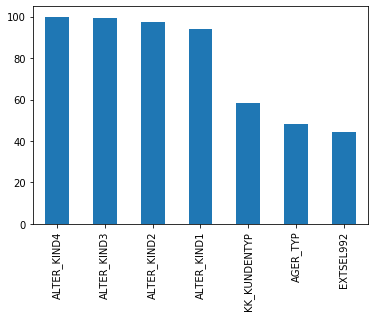

In [29]:
customers_missing_data_df[customers_missing_data_df.perc_of_miss > 30].perc_of_miss.plot(kind='bar');
plt.show()

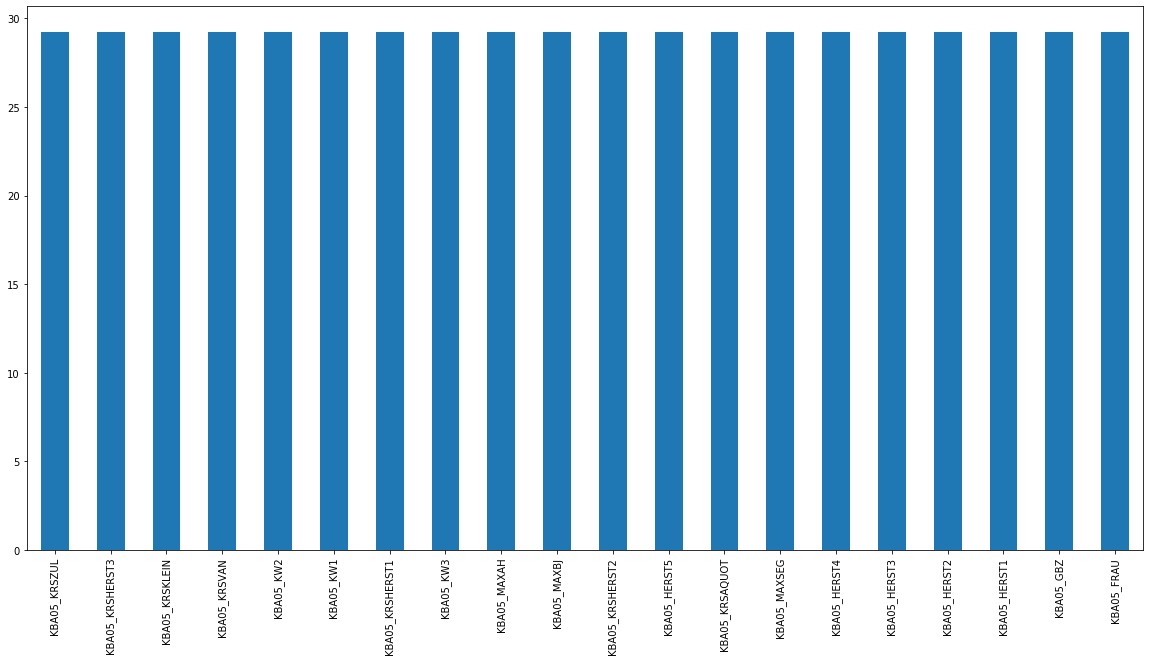

In [39]:
customers_missing_data_df[customers_missing_data_df.perc_of_miss < 30].perc_of_miss[:20].plot(figsize = (20, 10), kind = 'bar');
plt.show()

In [40]:
azdias_missing_data_df = extract_missing_data_cols(filtered_azdias)
azdias_missing_data_df

,num,perc_of_miss
ALTER_KIND4,890016,99.86
ALTER_KIND3,885051,99.31
ALTER_KIND2,861722,96.69
ALTER_KIND1,810163,90.90
AGER_TYP,677503,76.02
...,...,...
LP_LEBENSPHASE_GROB,4854,0.54
LP_FAMILIE_FEIN,4854,0.54
RETOURTYP_BK_S,4854,0.54
CJT_TYP_1,4854,0.54


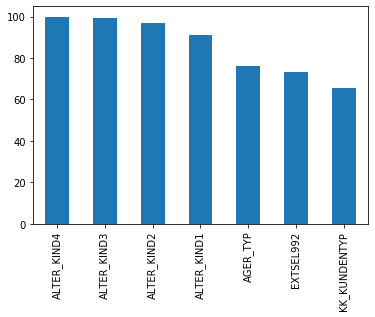

In [41]:
azdias_missing_data_df[azdias_missing_data_df.perc_of_miss > 30].perc_of_miss.plot(kind='bar');
plt.show()

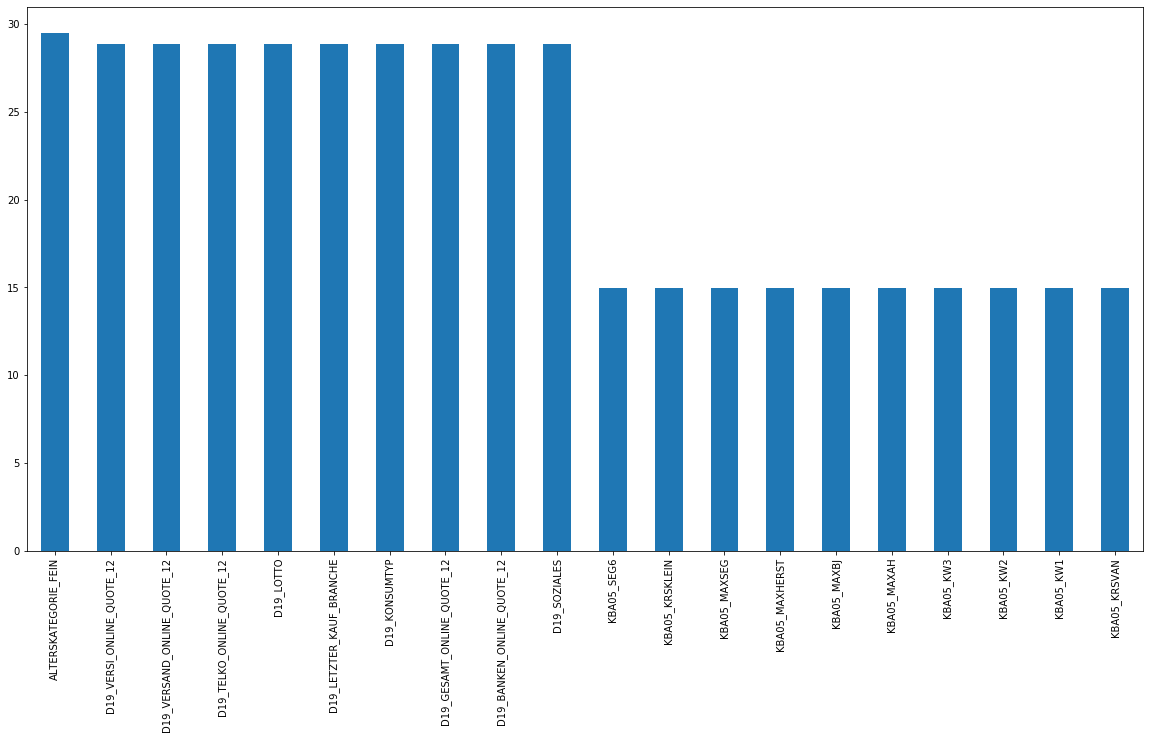

In [42]:
azdias_missing_data_df[azdias_missing_data_df.perc_of_miss < 30].perc_of_miss[:20].plot(figsize = (20, 10), kind = 'bar');
plt.show()

In [43]:
merged = azdias_missing_data_df.reset_index()
merged.rename(columns={'perc_of_miss':'azdias_miss'}, inplace=True)
del merged["num"]
merged

,index,azdias_miss
0,ALTER_KIND4,99.86
1,ALTER_KIND3,99.31
2,ALTER_KIND2,96.69
3,ALTER_KIND1,90.90
4,AGER_TYP,76.02
...,...,...
272,LP_LEBENSPHASE_GROB,0.54
273,LP_FAMILIE_FEIN,0.54
274,RETOURTYP_BK_S,0.54
275,CJT_TYP_1,0.54


In [44]:
temp_cus = customers_missing_data_df.reset_index()
temp_cus.rename(columns={'perc_of_miss':'cust_miss'}, inplace=True)
del temp_cus["num"]
temp_cus


,index,cust_miss
0,ALTER_KIND4,99.88
1,ALTER_KIND3,99.33
2,ALTER_KIND2,97.34
3,ALTER_KIND1,93.86
4,KK_KUNDENTYP,58.41
...,...,...
272,RETOURTYP_BK_S,1.68
273,CJT_KATALOGNUTZER,1.68
274,LP_STATUS_FEIN,1.68
275,LP_STATUS_GROB,1.68


In [47]:
merged = merged.merge(temp_cus, on='index')
merged

,index,azdias_miss,cust_miss
0,ALTER_KIND4,99.86,99.88
1,ALTER_KIND3,99.31,99.33
2,ALTER_KIND2,96.69,97.34
3,ALTER_KIND1,90.90,93.86
4,AGER_TYP,76.02,48.06
...,...,...,...
272,LP_LEBENSPHASE_GROB,0.54,1.68
273,LP_FAMILIE_FEIN,0.54,1.68
274,RETOURTYP_BK_S,0.54,1.68
275,CJT_TYP_1,0.54,1.68


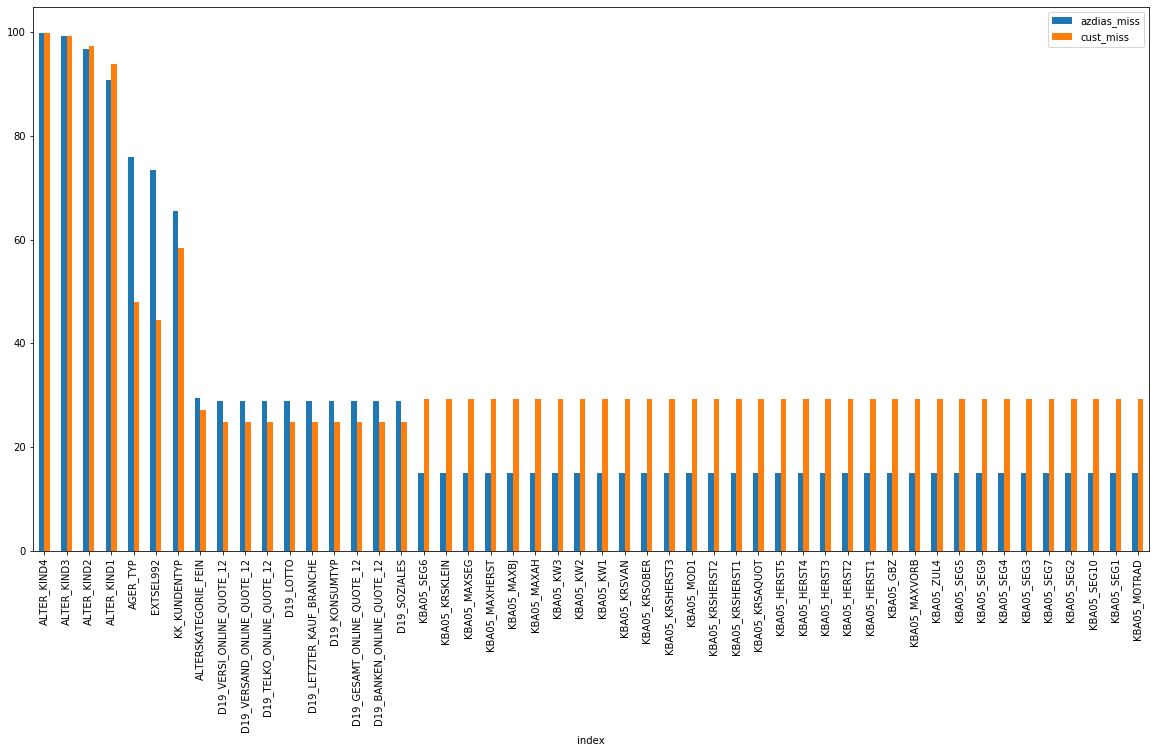

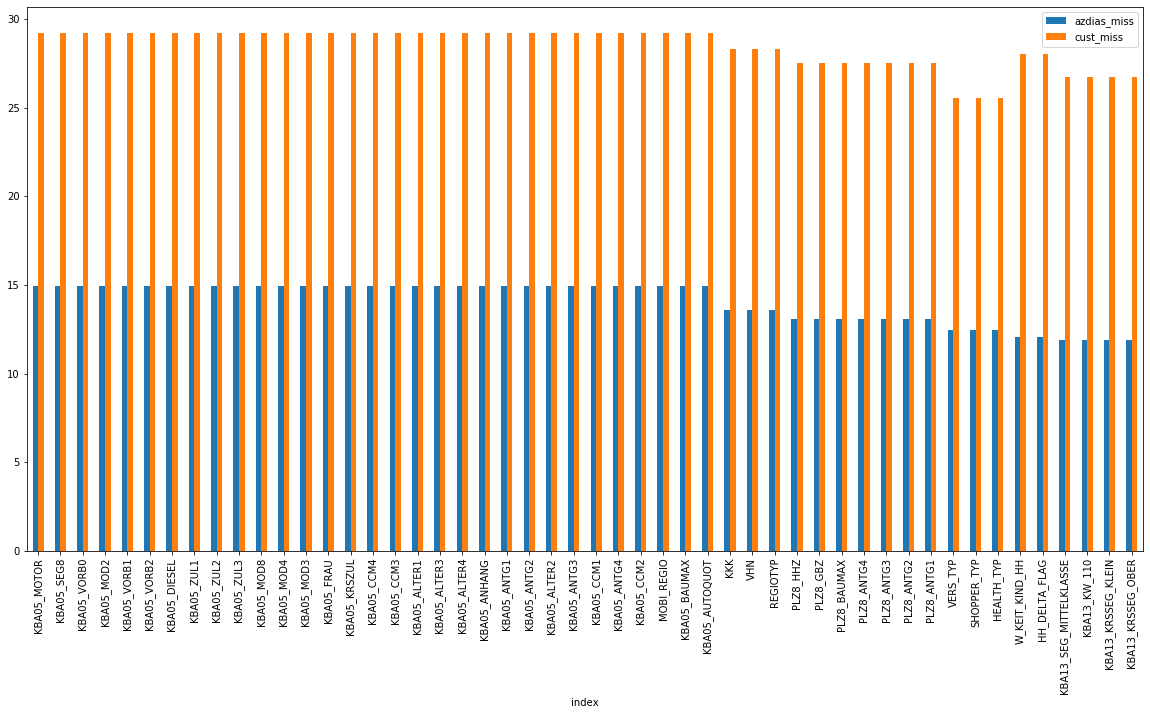

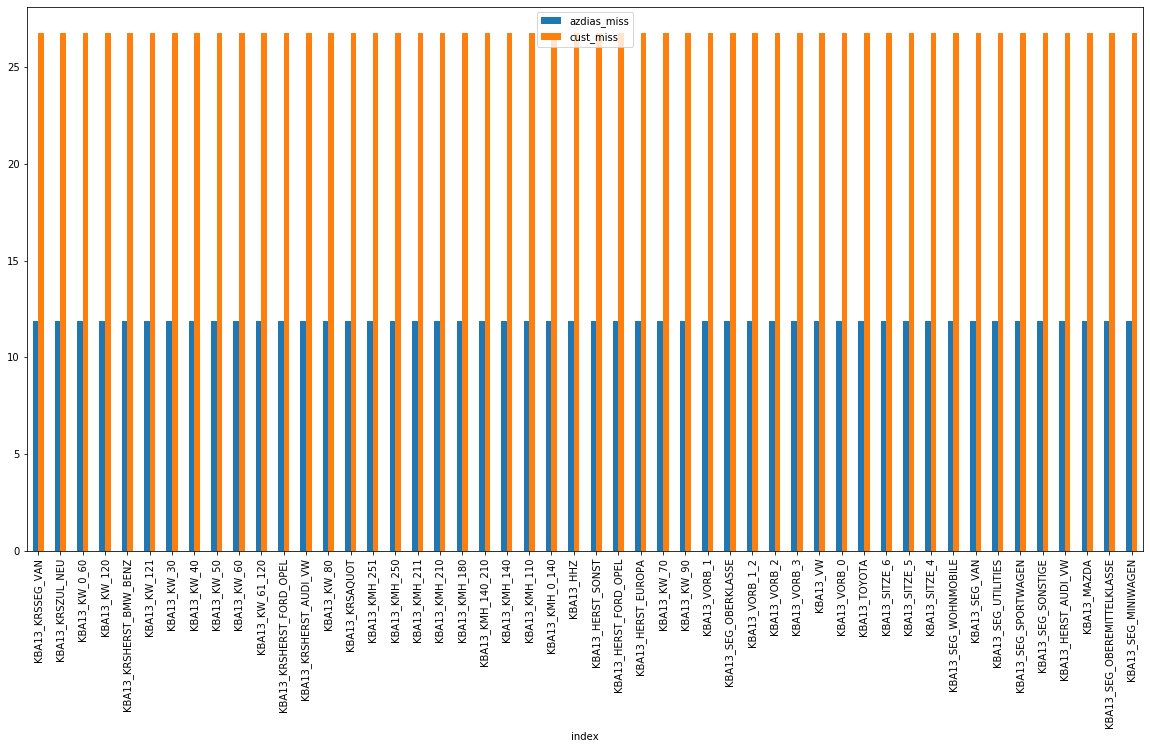

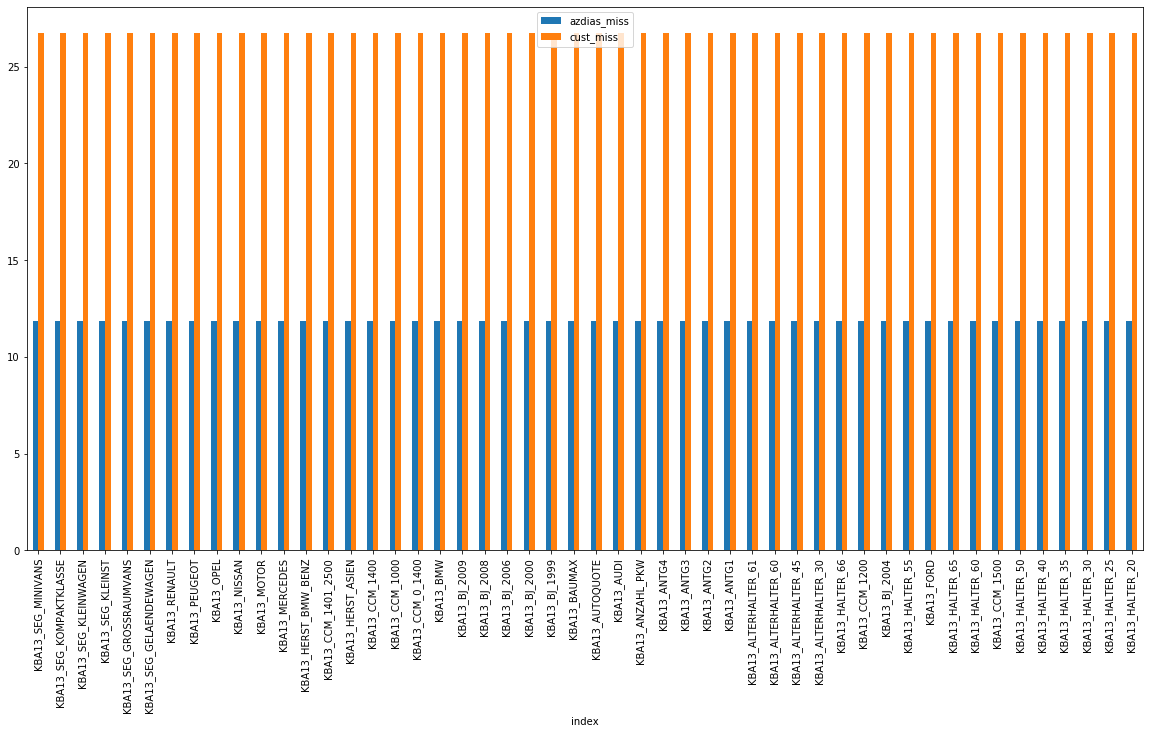

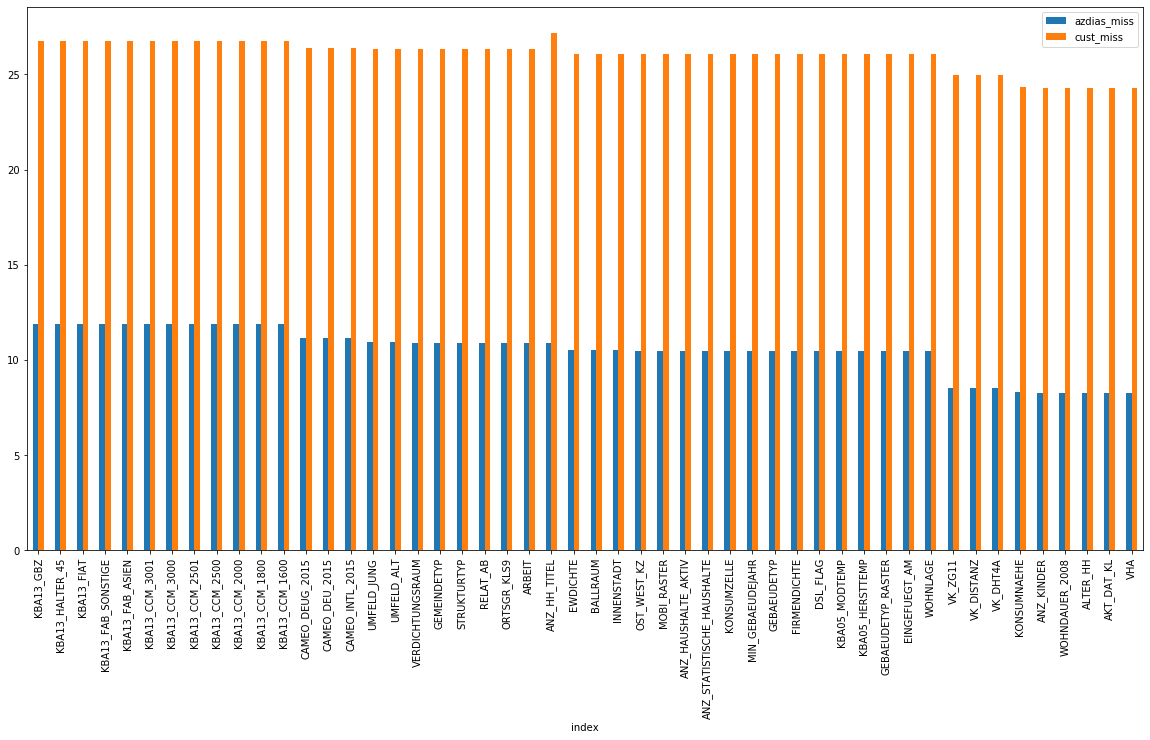

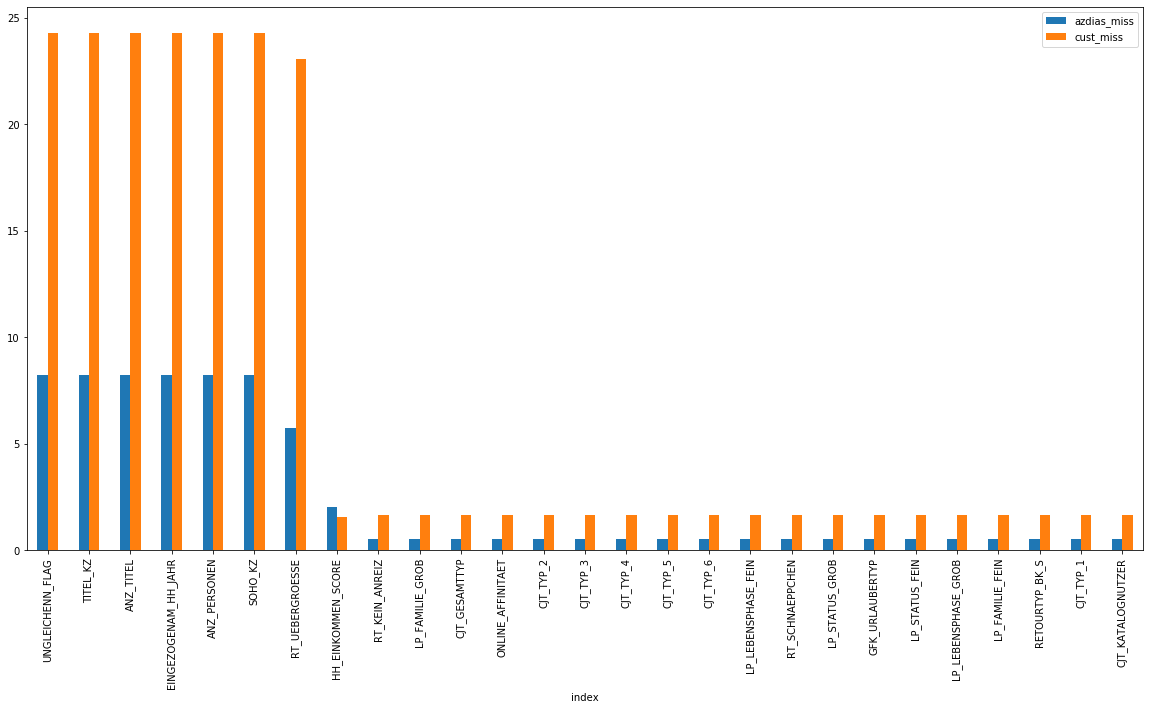

In [53]:
for i in range(0, len(merged), 50):
    
    merged[i:i+50].plot(x ='index', figsize=(20,10), kind = 'bar')

In [61]:
merged_unique = set(list(merged['index']))
print(len(attribuets_desc_unique & merged_unique))

221


In [69]:
cols_to_drop = list(merged.loc[(merged['azdias_miss'] > 30) & (merged['cust_miss'] > 30)]['index'])
cols_to_drop

['ALTER_KIND4',
 'ALTER_KIND3',
 'ALTER_KIND2',
 'ALTER_KIND1',
 'AGER_TYP',
 'EXTSEL992',
 'KK_KUNDENTYP']

In [76]:
print(attribuets_desc_unique & set(cols_to_drop))

{'AGER_TYP'}


In [71]:
filtered_azdias = filtered_azdias.drop(cols_to_drop, axis = 1)
filtered_customers = filtered_customers.drop(cols_to_drop, axis = 1)

In [74]:
print(filtered_azdias.shape)
print(filtered_customers.shape)

(891221, 359)
(191652, 362)


In [75]:
print('Post-filtered Azdias df, no of actual NaN values: ', filtered_azdias.isna().sum().sum())

Post-filtered Azdias df, no of actual NaN values:  29141913


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [ ]:
zip -r project.zip .